In [2]:
import pandas as pd
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import os
from scipy import stats
import seaborn as sns

# Utils

## Data Processing

In [3]:
def process(path): 
# Return transpose array of the csv file given
    if 'div' not in path and 'subs' not in path:
        return []
    else:
        print(path)
    df = pd.read_csv(path,header = None)
    Z = np.array(df)
    return Z

In [4]:
def shapiro_test(data):
# Test the given data whether is normal distributed or not
    try:
        shapiro_test = stats.shapiro(data)
    except:
        #print("Shapiro test fails")
        return
    if shapiro_test.pvalue<0.01:
        #print(f"Reject: p-value {shapiro_test.pvalue}")
        return False # Reject H0:data is normal distributed
    else:
        return True # Cannot reject H0: data may be normal distributed

In [5]:
def find_threshold(Z):
# Find a suitable threshold for data given to splitted into 2 normal distributed groups
    bins = [(np.max(Z)-np.min(Z))/2+np.min(Z)]
    return bins
    bins = []
    step = (np.max(Z)-np.min(Z))/1000
    for i in np.arange(np.min(Z)+step,np.max(Z),step):
        z_dig = np.digitize(Z,[i])
        D = (1-z_dig)*Z
        class1 = (z_dig*Z).flatten()
        class2 = ((1-z_dig)*Z).flatten()
        class1 = class1[class1 != 0]
        class2 = class2[class2 != 0]
        if shapiro_test(class1) and shapiro_test(class2):
            bins.append(i)
    return bins

In [6]:
# Transform value map into dataframe with column: [value, X-coordinate, Y-coordinate]
def transform(Z):
    values = Z.flatten()
    
    x_coor = []
    y_coor = []
    # x-coordinates
    for i in range(len(Z)):
        x_coor.append(np.arange(len(Z[0])))
    for i in range(len(Z)):
        y_coor.append(i*np.ones(len(Z[0])))
    df = {'value':values,'x':np.array(x_coor).flatten(),'y':np.array(y_coor).flatten().astype(int)}
    df = pd.DataFrame(df)
    return df

## Plot Function

In [7]:
def plot_colormap(data,title = "AUT and QUARTZ",path = ""):
    """
    Helper function to plot data with associated colormap.
    """
   # fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
    #                        constrained_layout=True, squeeze=False)
    figure, axes = plt.subplots(figsize=(data.shape[0]/5,data.shape[1]/5))
    psm = axes.pcolormesh(data, cmap='rainbow',rasterized=True)
    figure.colorbar(psm, ax=axes)
    axes.invert_yaxis()
    if abs(data.shape[1]-data.shape[0])<=1:
        print(data.shape[1],data.shape[0])
        axes.set_aspect('equal', adjustable='box')
    plt.title(title)
    #plt.savefig(path+" "+title)
    plt.show()

In [70]:
def plot_2stat(Z,z_dig,figname = None):
    fig = plt.figure(figsize=(Z.shape[1]/2,Z.shape[0]/3))
    # Add the first subplot to the top left of the grid
    ax1 = plt.subplot2grid((3,3),(0,0),colspan = 1,rowspan = 1)
    psm = ax1.pcolormesh(Z,cmap = 'rainbow',rasterized = True)
    fig.colorbar(psm,ax=ax1)
    ax1.set_title("Before process")
    
    # Add the second subplot to the bottom right of the grid
    ax2 = plt.subplot2grid((3,3),(1,0),colspan = 1,rowspan = 1)
    psm2 = ax2.pcolormesh(z_dig, cmap='cool',rasterized=True)
    fig.colorbar(psm2, ax=ax2)
    ax2.set_title("After process")
    
    # Add the third subplot to the right area as a 2*2 square
    ax3 = plt.subplot2grid((3,3),(0,1),colspan = 2,rowspan = 2)
    class1 = (z_dig*Z).flatten()
    class2 = ((1-z_dig)*Z).flatten()
    class1 = class1[class1 != 0]
    class2 = class2[class2 != 0]
    mean1 = np.mean(class1)
    std1 = np.std(class1)
    mean2 = np.mean(class2)
    std2 = np.std(class2)
    print(len(class1))
    ax3.hist((class1,class2),bins=100,label = ("{:.3f} +- {:.3f}".format(mean1,std1),"{:.3f} +- {:.3f}".format(mean2,std2)),color = ('aqua','magenta'))
    ax3.legend(prop={'size': 30})

    if figname:
        plt.savefig(figname)
    plt.show()

In [9]:
def plot_labels(Z,label,dim1 = 49,dim2 = 50):
    # Reshape into dim1*dim2
    label = label.reshape(dim1,dim2)

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(21, 7))
    sns.heatmap(Z,ax=ax1)
    sns.heatmap(label,ax = ax2)
    plt.show()
    #p = sns.scatterplot(data=Zt['value'], x=Zt['x'], y=Zt['y'], hue=clf.predict(Zt), legend="full", palette="deep")
    #sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
    #plt.show()

In [10]:
def plot_3d(Z,ele_deg=60,azi_deg=35):
    X = np.linspace(0, Z.shape[1]-1, Z.shape[1])
    Y = np.linspace(0, Z.shape[0]-1, Z.shape[0])
    
    fig = plt.figure(figsize = (10,20))
    for i in range(2):
        ax = fig.add_subplot(1,2,i+1,projection='3d')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.view_init(ele_deg, azi_deg)
        ax.invert_xaxis()
        if i==0:
            ax.contour3D(X, Y, Z,50, cmap='rainbow')
        if i==1:
            Zt = transform(Z)
            ax.scatter(Zt['x'], Zt['y'],Zt['value'], c=Z, cmap='rainbow')
    plt.show()

In [11]:
def plot_3d_scatter(Z,ele_deg = 60,azi_deg = 35):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    X = np.linspace(0, 48, 49)
    Y = np.linspace(0, 59, 50)
    ax.scatter(X,Y, Z, cmap='rainbow',linewidth = 0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(ele_deg, azi_deg);
    plt.show()

# DFS 

In [43]:
# Search for local minimum, then expand until gradient is zero
# DFS
# 1. Check gradient of each point, to x+- and y+-, should be positive
# 2. Check the gradient not = 0
# 3. If gradient not = 0, active the node, continue search (Queue)

def fourGradCheck(Z,x,y,direction = None,threshold = 0):
    if x>0:
        if Z[x-1][y]-Z[x][y]<threshold and direction != "right":
            return False
    if x<Z.shape[0]-1:
        if Z[x+1][y]-Z[x][y]<threshold and direction != "left":
            return False
    if y>0:
        if Z[x][y-1]-Z[x][y]<threshold and direction != "down":
            return False
    if y<Z.shape[1]-1:
        if Z[x][y+1]-Z[x][y]<threshold and direction != "up":
            return False
    return True

def fourDirCheck(Z,x,y,threshold,direction = None):
    if x>0:
        if Z[x-1][y]>=threshold and direction != "right":
            return False
    if x<Z.shape[0]-1:
        if Z[x+1][y]>=threshold and direction != "left":
            return False
    if y>0:
        if Z[x][y-1]>=threshold and direction != "down":
            return False
    if y<Z.shape[1]-1:
        if Z[x][y+1]>=threshold and direction != "up":
            return False
    return True

def dfs_point(Z,x,y,direction = "None"):
    global median,act
    if x<0 or x>=Z.shape[0] or y<0 or y>=Z.shape[1]:
        return

    if (x,y) in act:
        return
    else:
        if direction == None:
            if fourGradCheck(Z,x,y,direction = direction):
                # Push into act
                act.append((x,y))
                # dfs on point surrounding
                if direction == 'None':
                    dfs_point(Z,x-1,y,direction = 'left')
                    dfs_point(Z,x+1,y,direction = 'right')
                    dfs_point(Z,x,y-1,direction = 'up')
                    dfs_point(Z,x,y+1,direction = 'down')
                elif direction == 'right':
                    dfs_point(Z,x+1,y,direction = 'right')
                    dfs_point(Z,x,y-1,direction = 'up')
                    dfs_point(Z,x,y+1,direction = 'down')
                elif direction == 'left':
                    dfs_point(Z,x-1,y,direction = 'left')
                    dfs_point(Z,x,y-1,direction = 'up')
                    dfs_point(Z,x,y+1,direction = 'down')
                elif direction == "up":
                    dfs_point(Z,x-1,y,direction = 'left')
                    dfs_point(Z,x+1,y,direction = 'right')
                    dfs_point(Z,x,y-1,direction = 'up')
                elif direction == 'down':
                    dfs_point(Z,x-1,y,direction = 'left')
                    dfs_point(Z,x+1,y,direction = 'right')
                    dfs_point(Z,x,y+1,direction = 'down')
        else:
            if fourDirCheck(Z,x,y,median,direction = direction):
                # Push into act
                act.append((x,y))
                # dfs on point surrounding
                if direction == 'None':
                    dfs_point(Z,x-1,y,direction = 'left')
                    dfs_point(Z,x+1,y,direction = 'right')
                    dfs_point(Z,x,y-1,direction = 'up')
                    dfs_point(Z,x,y+1,direction = 'down')
                elif direction == 'right':
                    dfs_point(Z,x+1,y,direction = 'right')
                    dfs_point(Z,x,y-1,direction = 'up')
                    dfs_point(Z,x,y+1,direction = 'down')
                elif direction == 'left':
                    dfs_point(Z,x-1,y,direction = 'left')
                    dfs_point(Z,x,y-1,direction = 'up')
                    dfs_point(Z,x,y+1,direction = 'down')
                elif direction == "up":
                    dfs_point(Z,x-1,y,direction = 'left')
                    dfs_point(Z,x+1,y,direction = 'right')
                    dfs_point(Z,x,y-1,direction = 'up')
                elif direction == 'down':
                    dfs_point(Z,x-1,y,direction = 'left')
                    dfs_point(Z,x+1,y,direction = 'right')
                    dfs_point(Z,x,y+1,direction = 'down') 

In [66]:
def dfs_emf(file):
    global median,act
    Z = process(file)
    median = np.median(Z.flatten())
    mean = np.mean(Z.flatten())
    act = [] # Active Point Found, (Tuple List)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            dfs_point(Z,i,j)
    z_dig = np.zeros(Z.shape)
    for act_point in act:
        z_dig[act_point[0]][act_point[1]] = 1
    plot_2stat(Z,z_dig,figname=file[:-4]+".png")

In [72]:
def dfs_cur(file):
    global median,act
    Z = process(file.replace("current_","EMF_"))
    median = np.median(Z.flatten())
    mean = np.mean(Z.flatten())
    act = [] # Active Point Found, (Tuple List)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            dfs_point(Z,i,j)
    z_dig = np.zeros(Z.shape)
    for act_point in act:
        z_dig[act_point[0]][act_point[1]] = 1
    Z = process(file)
    plot_2stat(Z,z_dig,figname=file[:-4]+".png")

# Main

In [46]:
# Find all the files
data_dir = "../data/221115_review/"
lst=os.listdir(data_dir)
files = []
for l in lst:
    if l[0] != '.':
        f_lst = os.listdir(data_dir+l)
        for f in f_lst:
            if '.png' not in f:
                files.append(data_dir+l+'/'+f)
Z = process(files[5])

../data/221115_review/A_221015_250nm_negative/22o15003.abf_EMF_div-pqty=25.csv


../data/221115_review/A_221015_250nm_negative/22o15003.abf_EMF_div-pqty=25.csv
../data/221115_review/A_221015_250nm_negative/22o15003.abf_current_div-pqty=25.csv
427


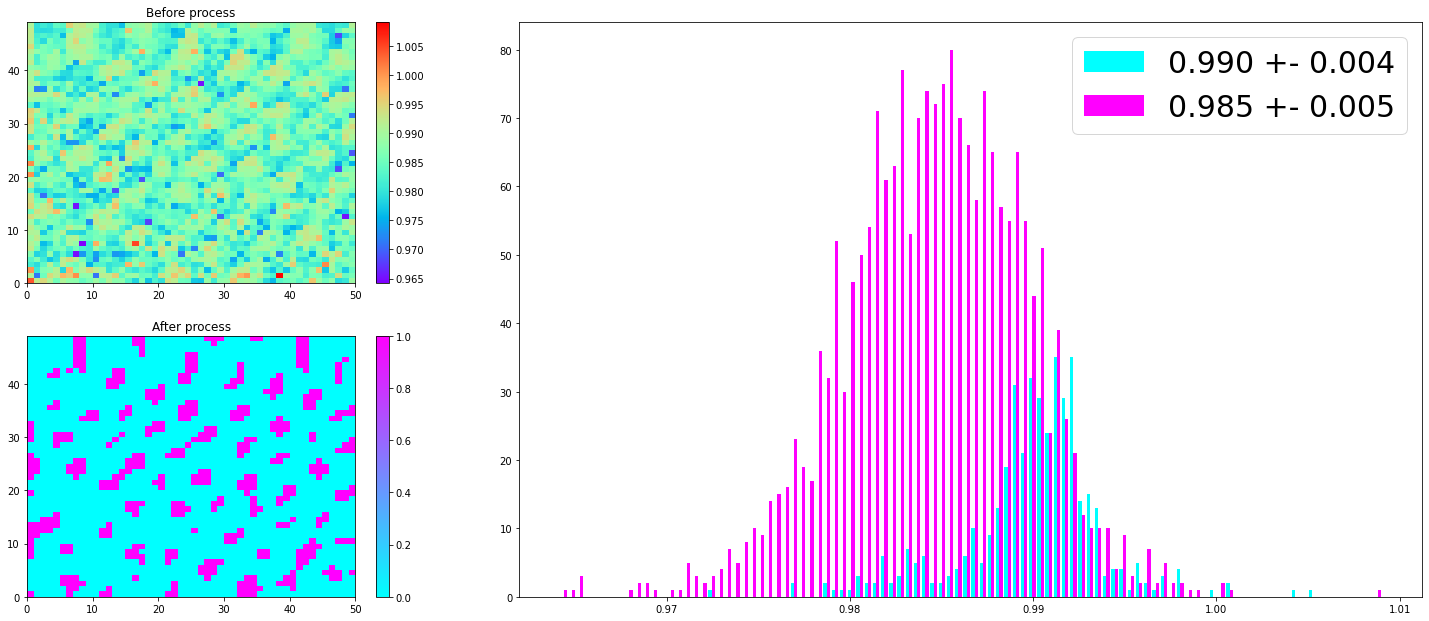

../data/221115_review/A_221015_250nm_negative/22o15003.abf_EMF_subs-pqty=25.csv
../data/221115_review/A_221015_250nm_negative/22o15003.abf_current_subs-pqty=25.csv
343


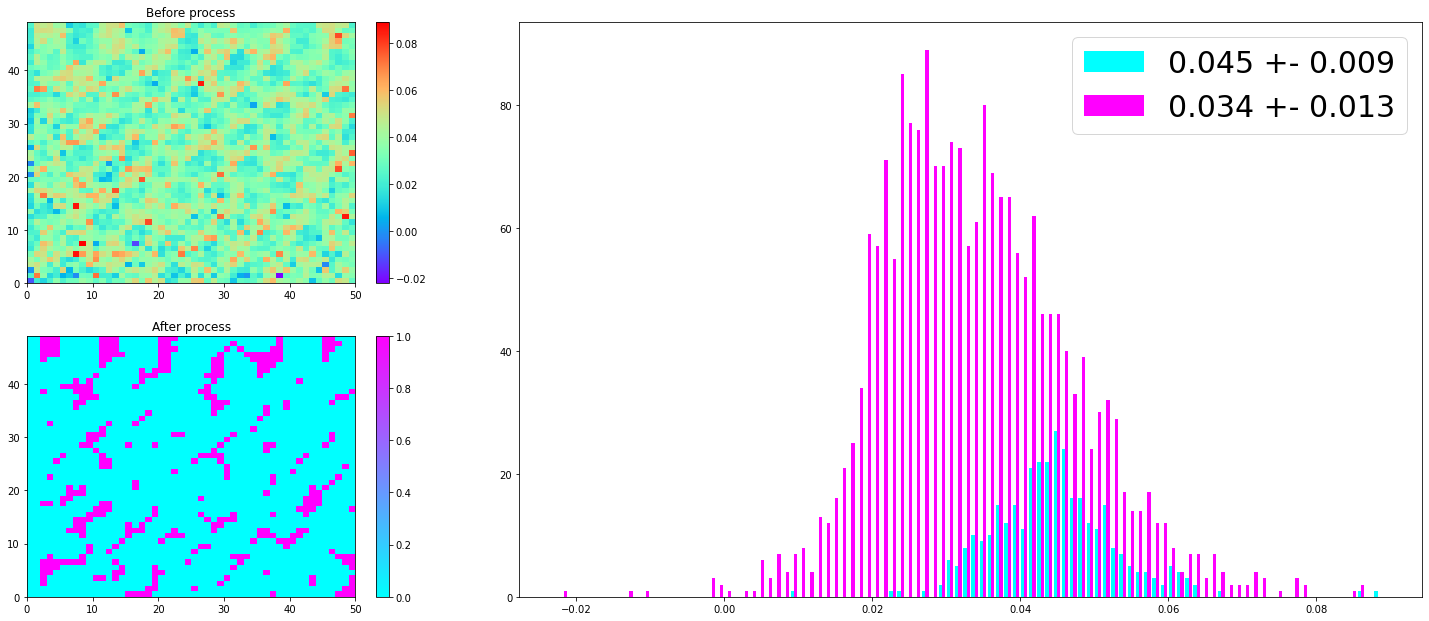

../data/221115_review/A_221015_250nm_negative/22o15003.abf_EMF_div-pqty=25.csv
427


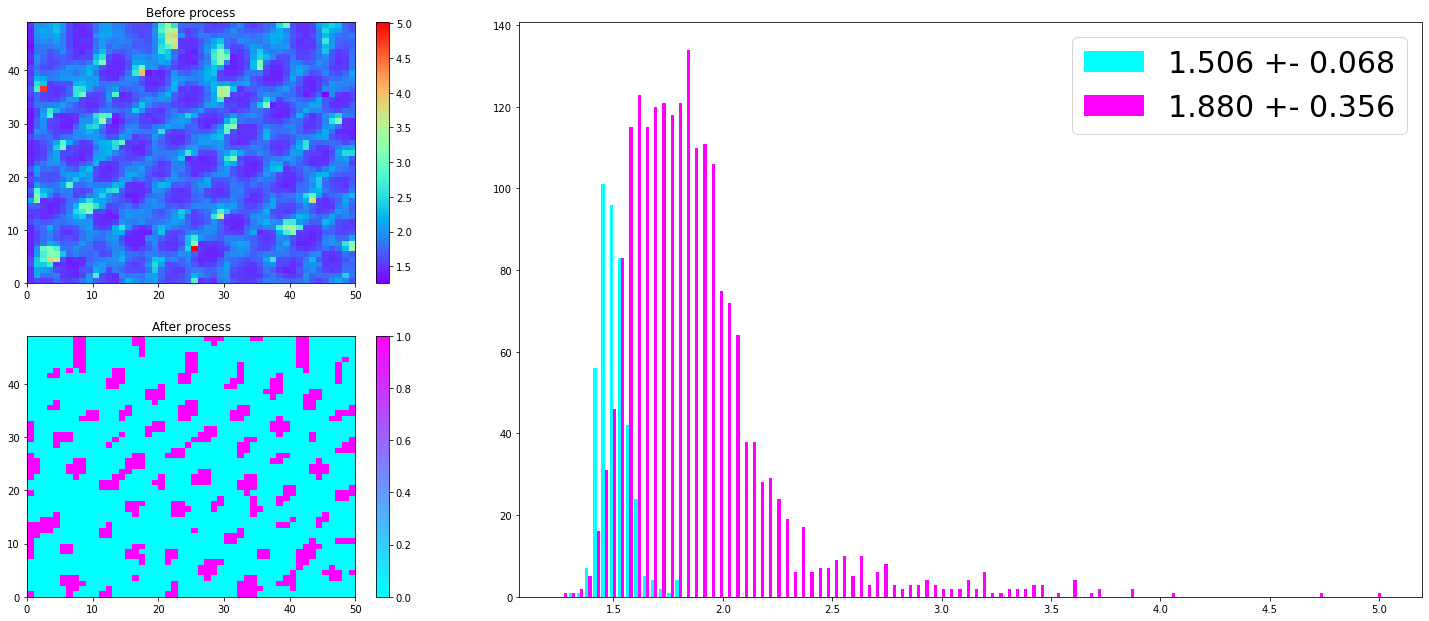

../data/221115_review/A_221015_250nm_negative/22o15003.abf_EMF_subs-pqty=25.csv
343


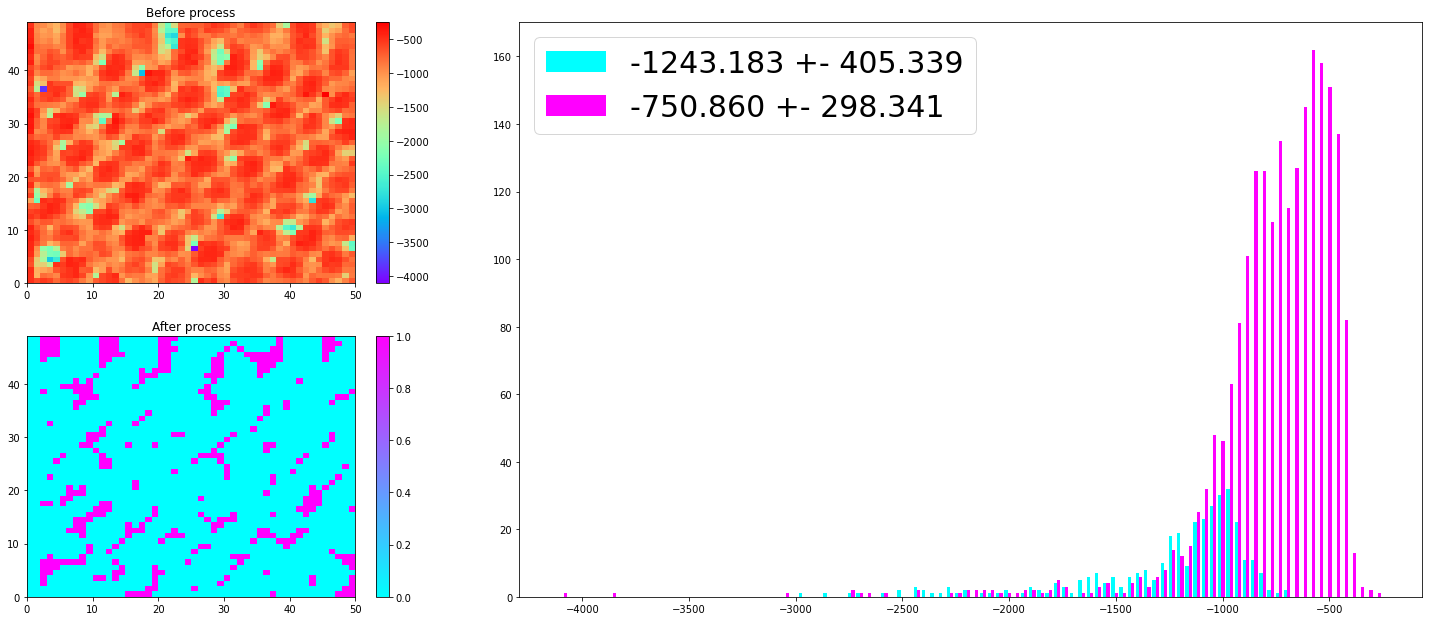

../data/221115_review/A_221015_250nm_positive/22o15002.abf_EMF_div-pqty=25.csv
../data/221115_review/A_221015_250nm_positive/22o15002.abf_current_div-pqty=25.csv
415


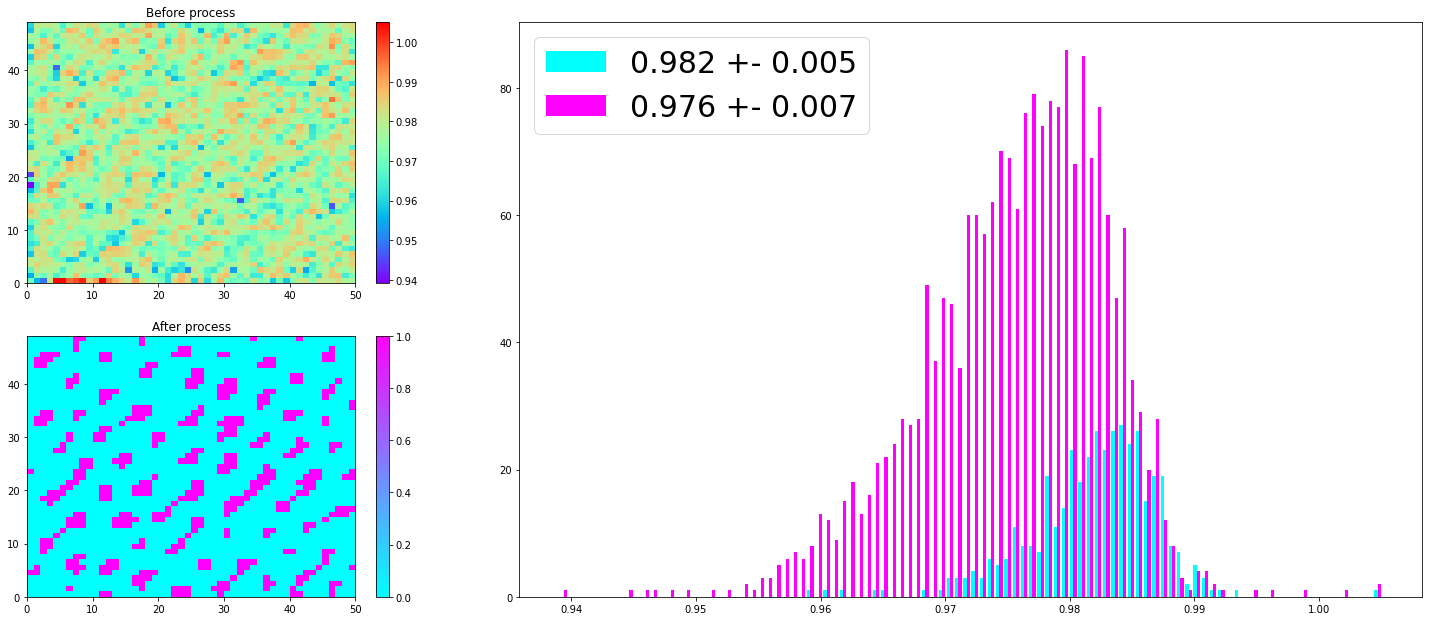

../data/221115_review/A_221015_250nm_positive/22o15002.abf_EMF_subs-pqty=25.csv
../data/221115_review/A_221015_250nm_positive/22o15002.abf_current_subs-pqty=25.csv
415


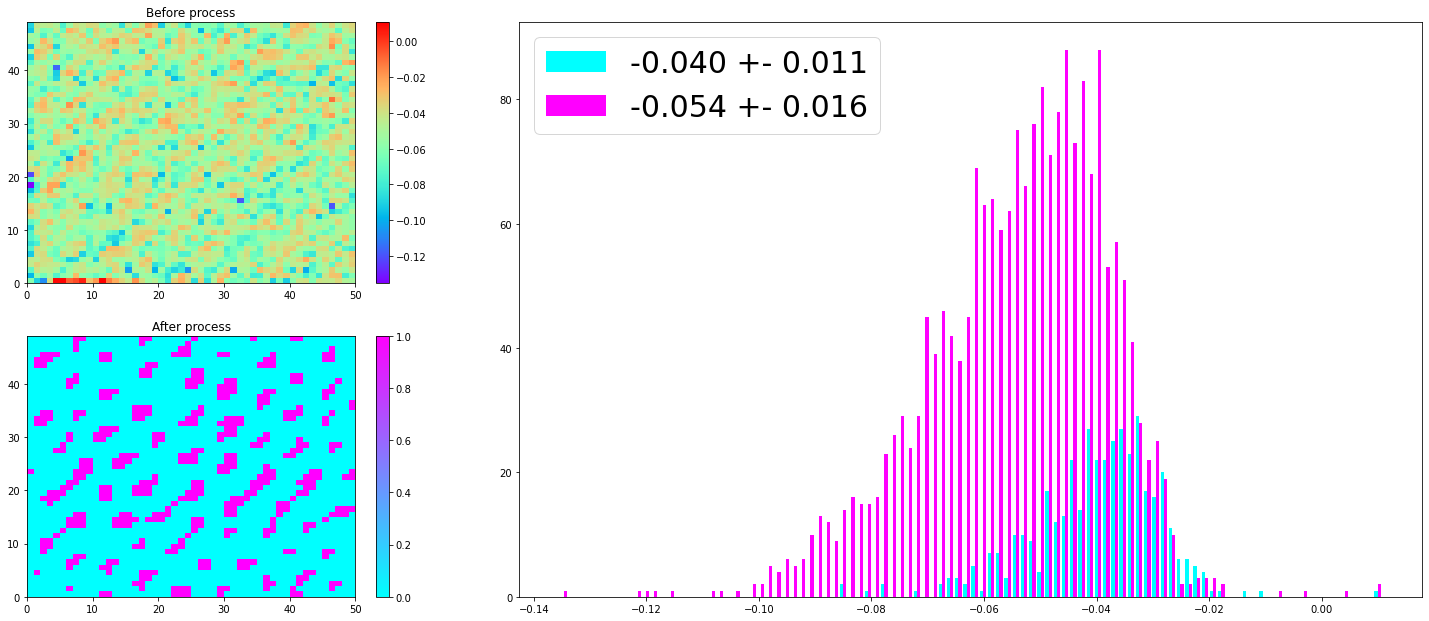

../data/221115_review/A_221015_250nm_positive/22o15002.abf_EMF_div-pqty=25.csv
415


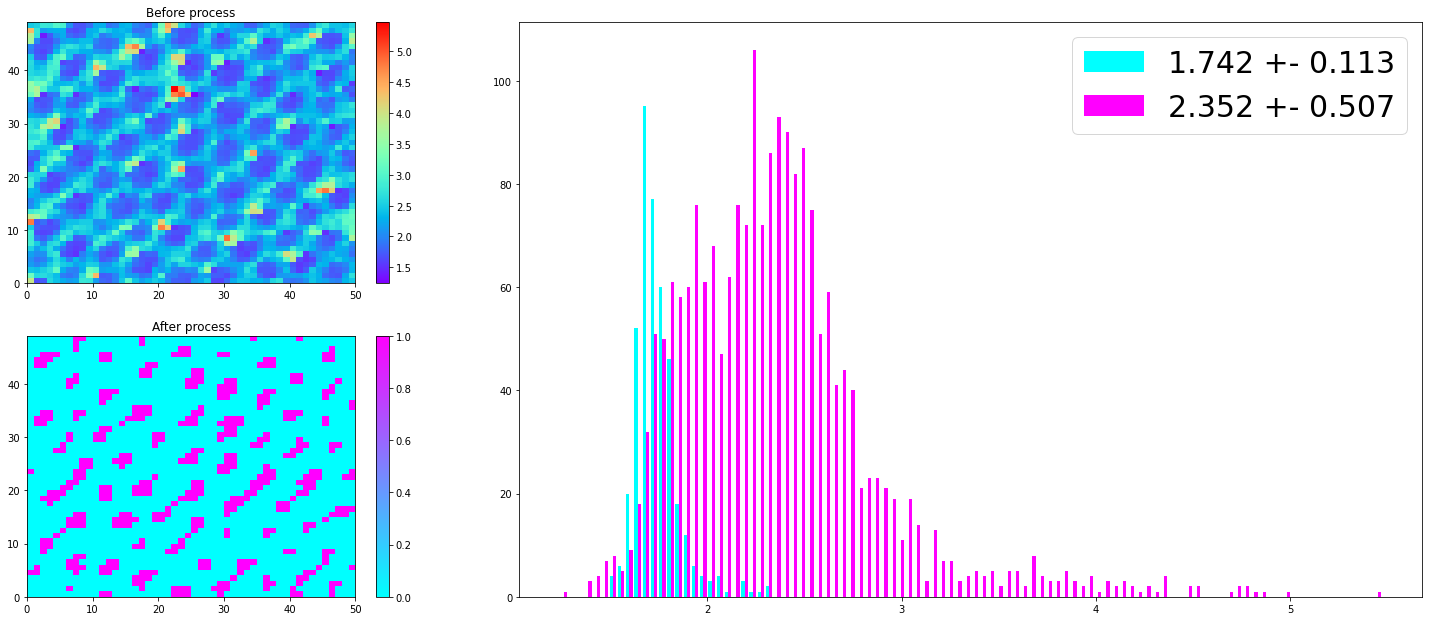

../data/221115_review/A_221015_250nm_positive/22o15002.abf_EMF_subs-pqty=25.csv
415


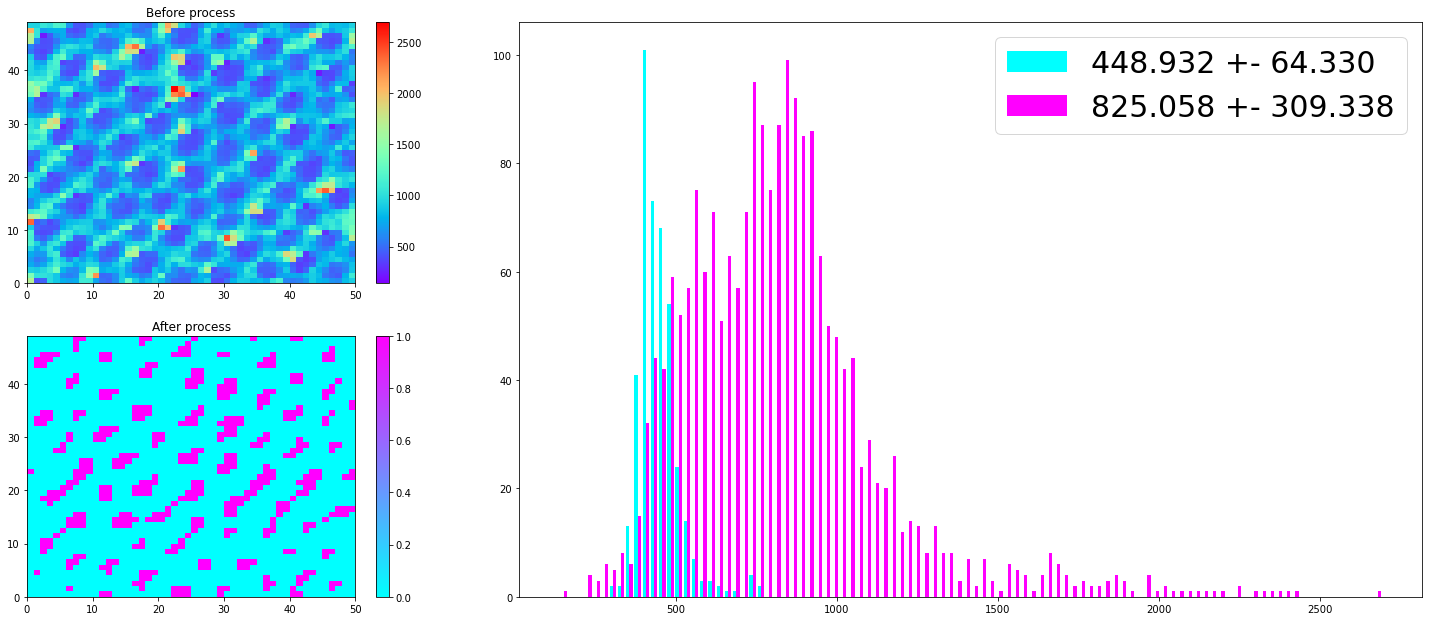

../data/221115_review/B_221109_380nm_negative/22n09004.abf_EMF_div-pqty=25.csv
../data/221115_review/B_221109_380nm_negative/22n09004.abf_current_div-pqty=25.csv
539


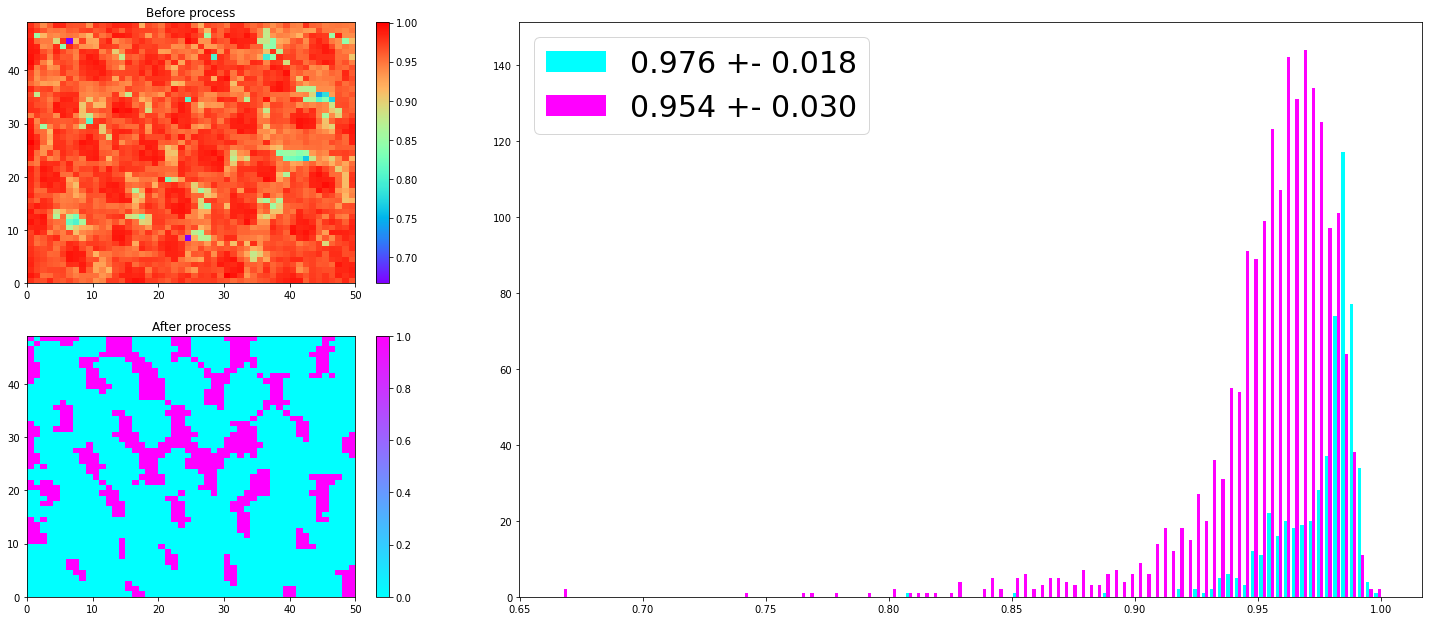

../data/221115_review/B_221109_380nm_negative/22n09004.abf_EMF_subs-pqty=25.csv
../data/221115_review/B_221109_380nm_negative/22n09004.abf_current_subs-pqty=25.csv
584


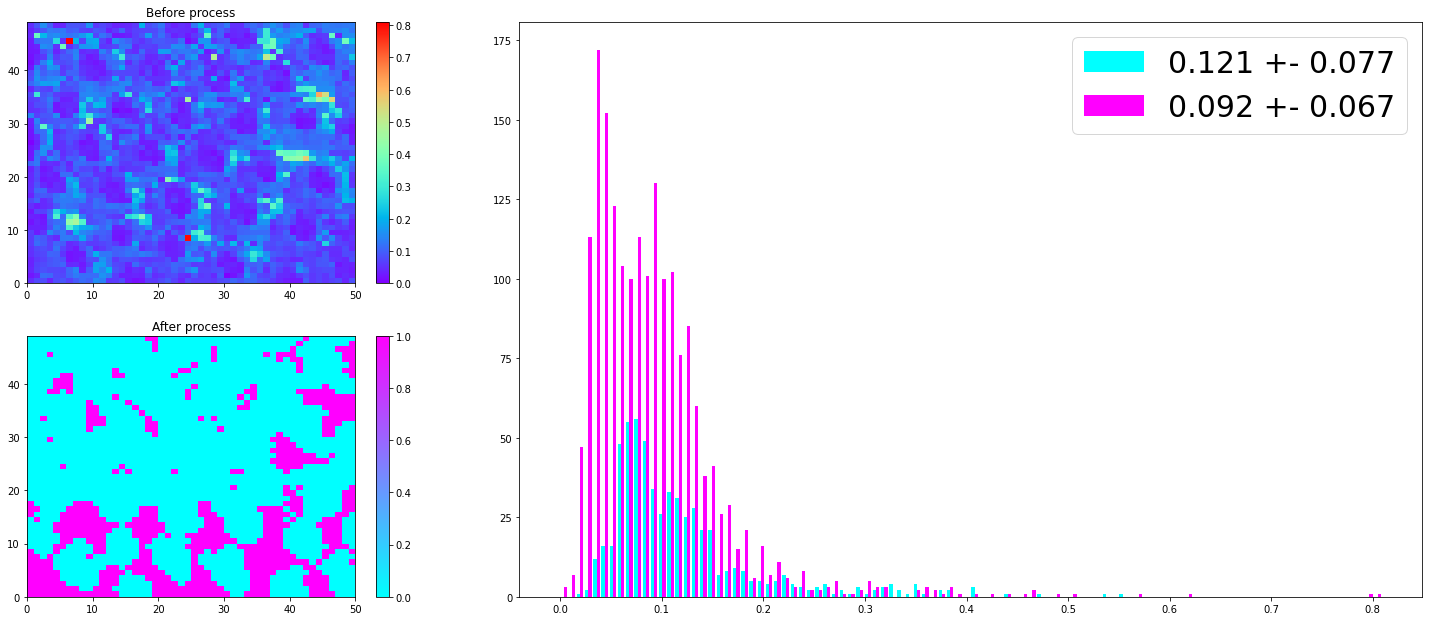

../data/221115_review/B_221109_380nm_negative/22n09004.abf_EMF_div-pqty=25.csv
539


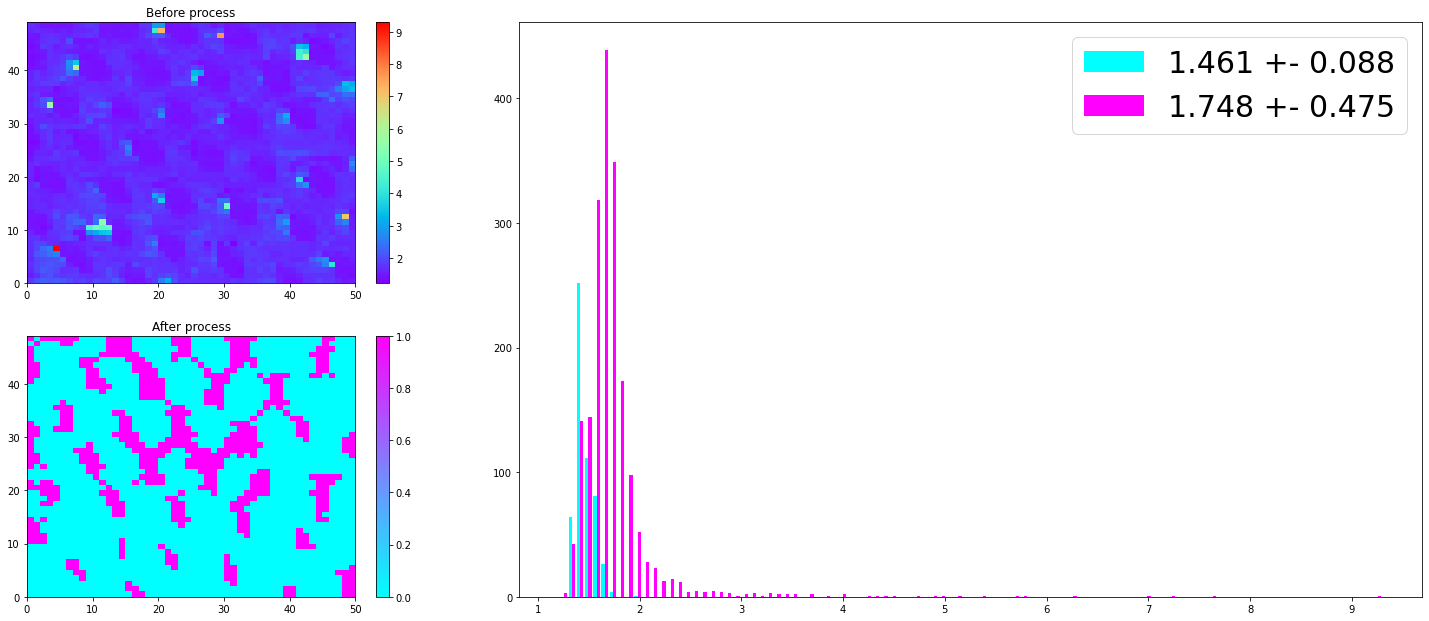

../data/221115_review/B_221109_380nm_negative/22n09004.abf_EMF_subs-pqty=25.csv
584


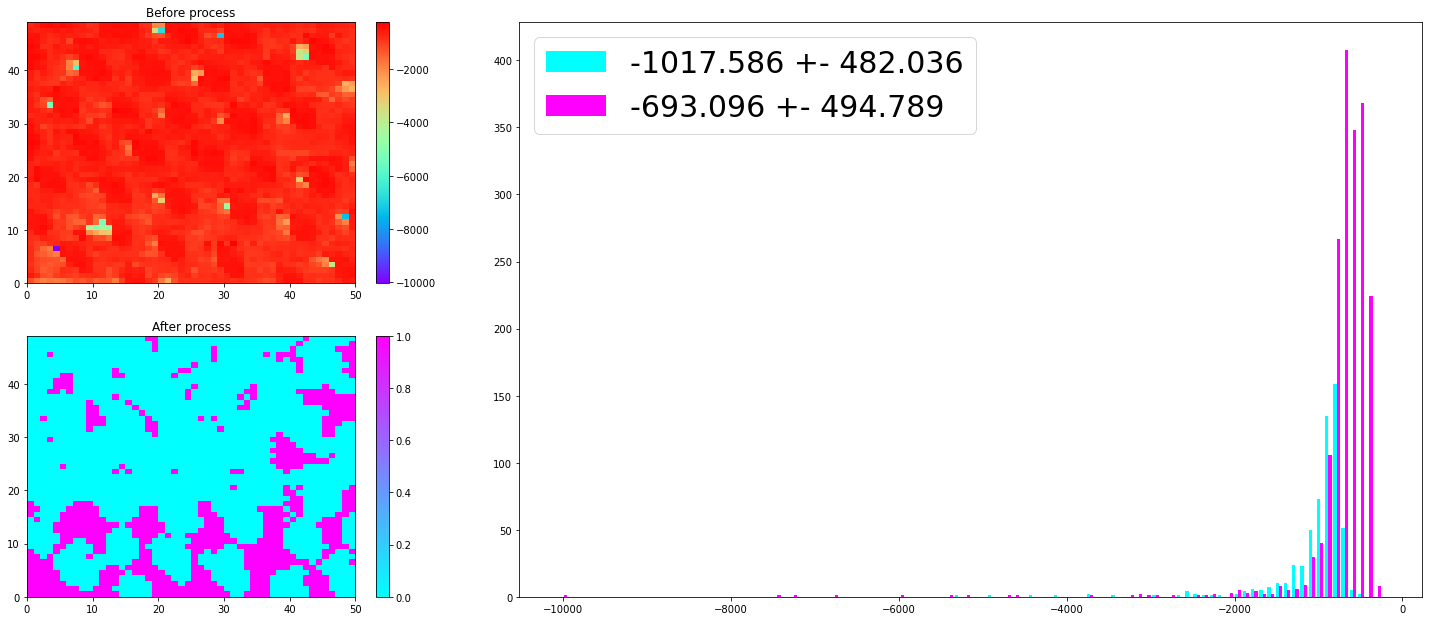

../data/221115_review/B_221109_380nm_positive/22n09005.abf_EMF_div-pqty=25.csv
../data/221115_review/B_221109_380nm_positive/22n09005.abf_current_div-pqty=25.csv
618


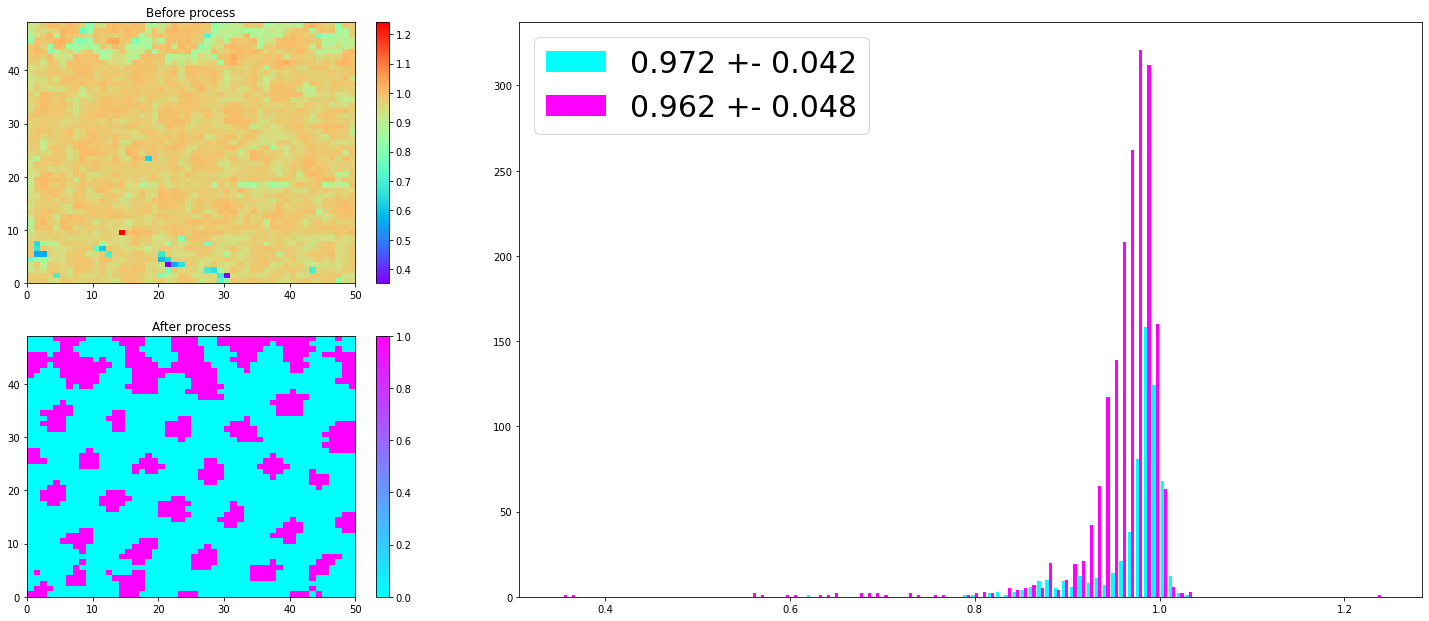

../data/221115_review/B_221109_380nm_positive/22n09005.abf_EMF_subs-pqty=25.csv
../data/221115_review/B_221109_380nm_positive/22n09005.abf_current_subs-pqty=25.csv
662


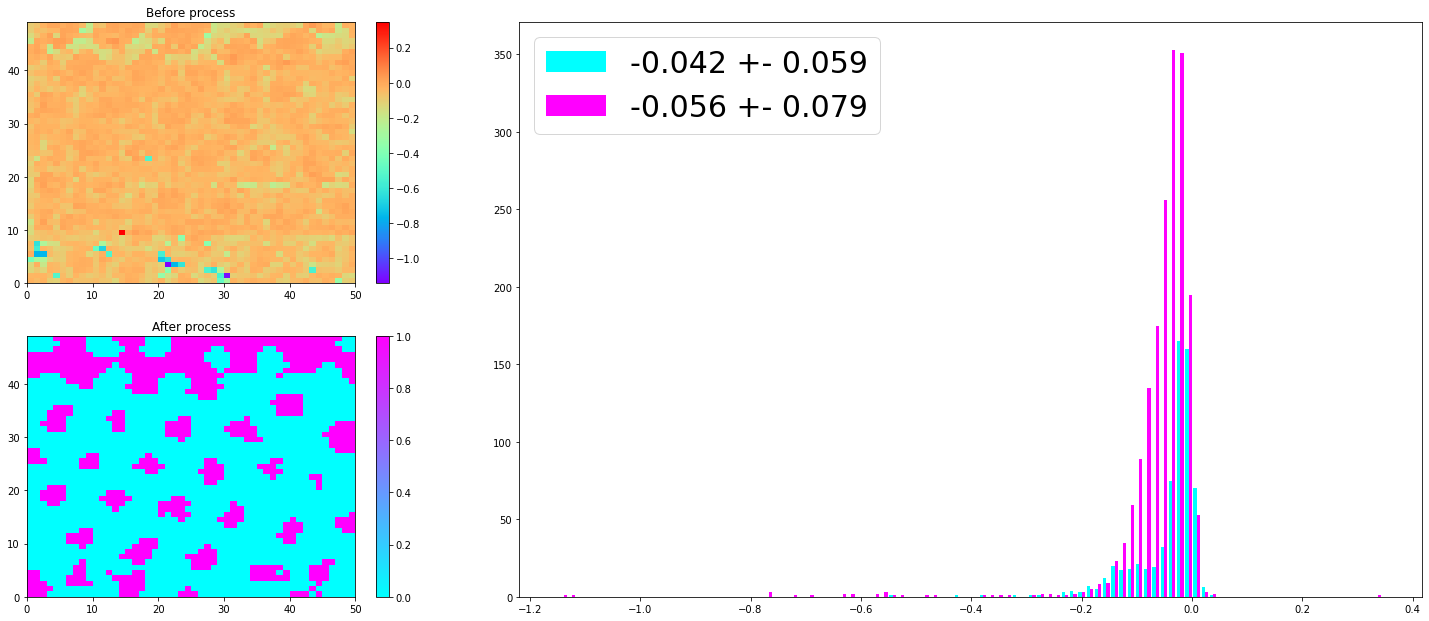

../data/221115_review/B_221109_380nm_positive/22n09005.abf_EMF_div-pqty=25.csv
618


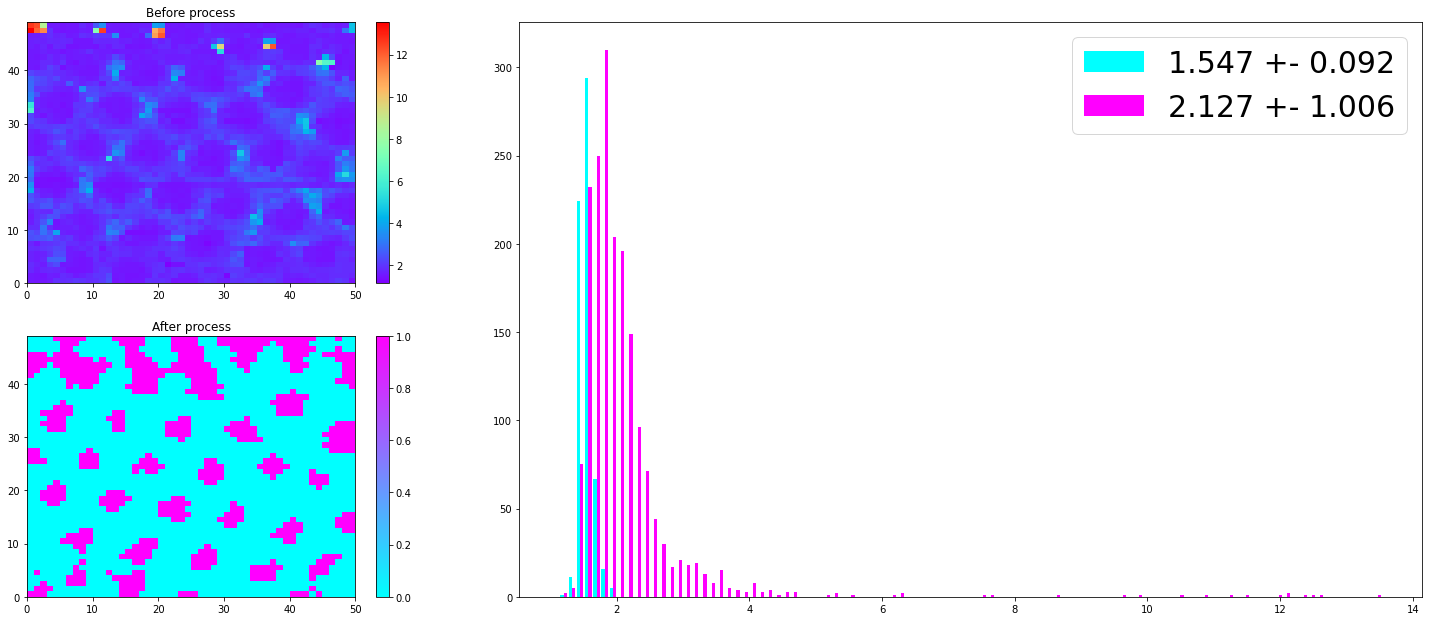

../data/221115_review/B_221109_380nm_positive/22n09005.abf_EMF_subs-pqty=25.csv
662


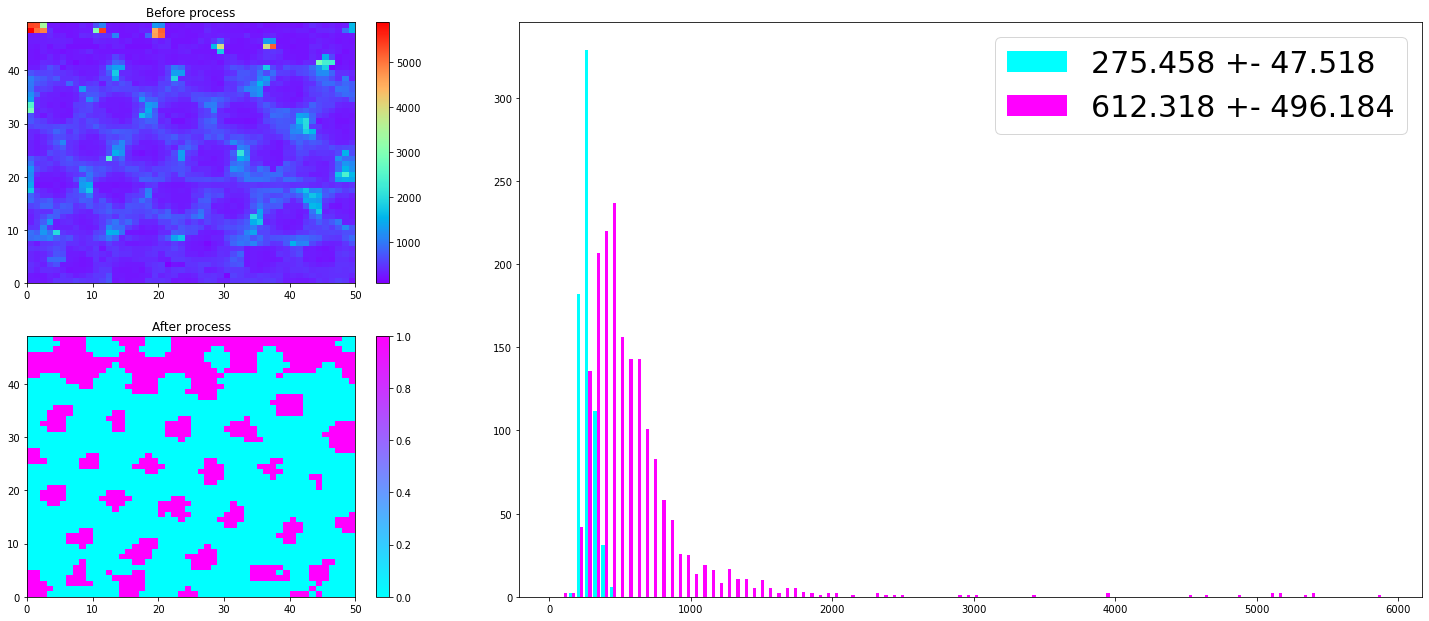

../data/221115_review/C_221015_480nm_negative/22o15010.abf_EMF_div-pqty=25.csv
../data/221115_review/C_221015_480nm_negative/22o15010.abf_current_div-pqty=25.csv
735


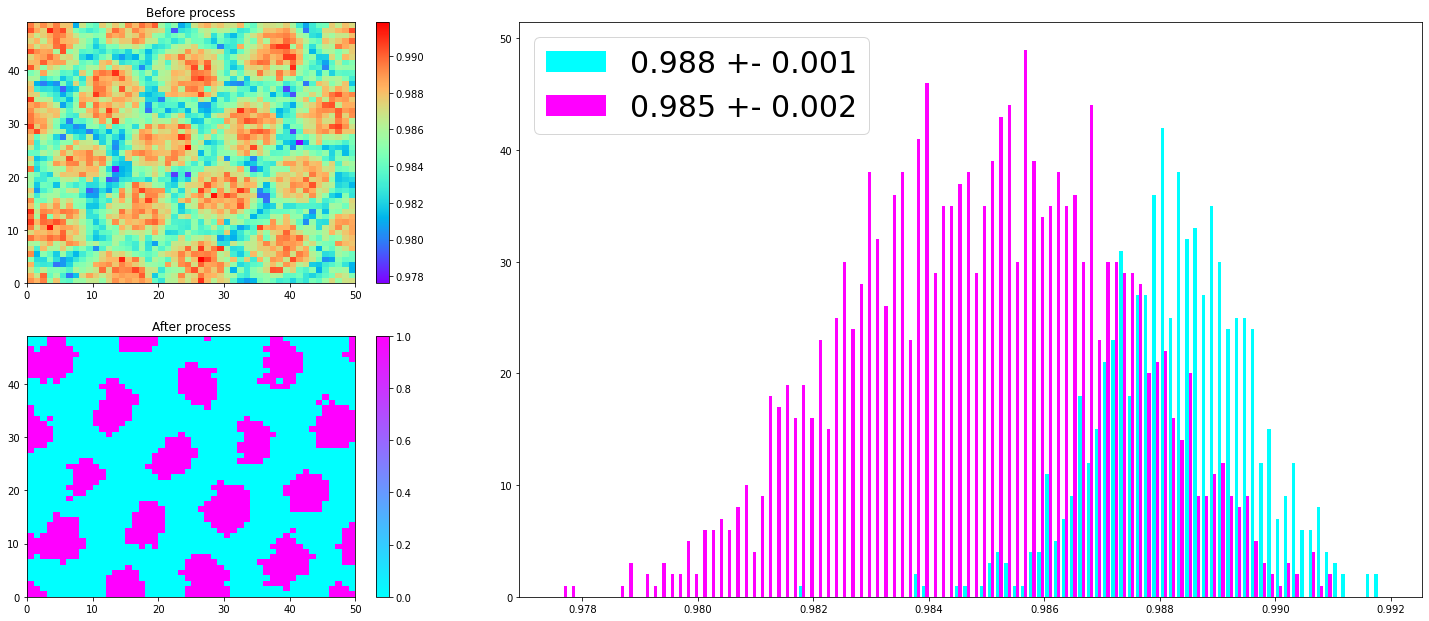

../data/221115_review/C_221015_480nm_negative/22o15010.abf_EMF_subs-pqty=25.csv
../data/221115_review/C_221015_480nm_negative/22o15010.abf_current_subs-pqty=25.csv
699


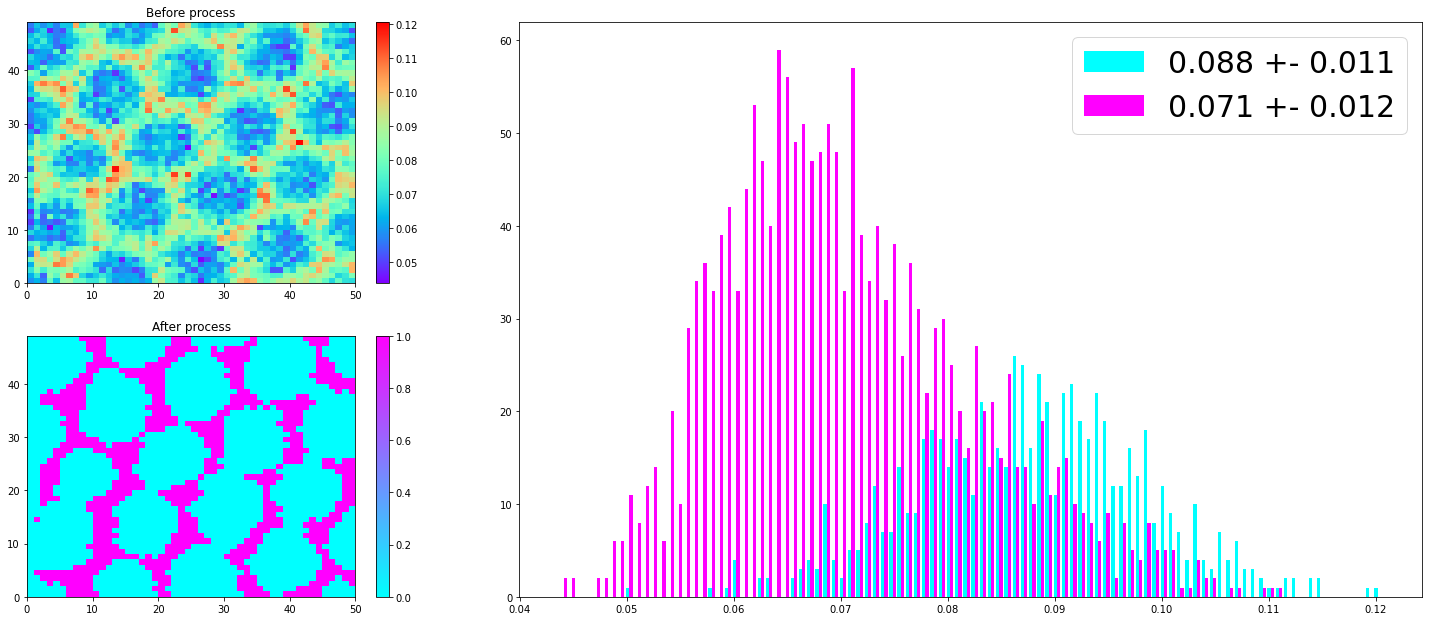

../data/221115_review/C_221015_480nm_negative/22o15010.abf_EMF_div-pqty=25.csv
735


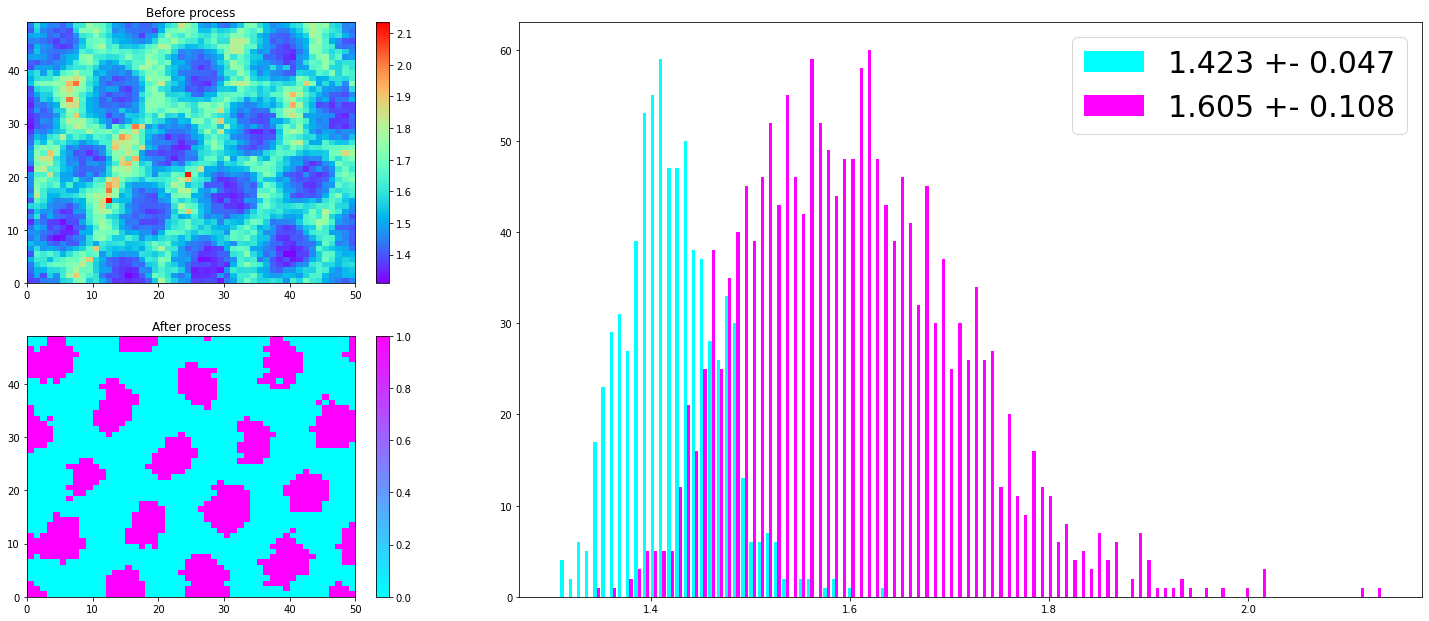

../data/221115_review/C_221015_480nm_negative/22o15010.abf_EMF_subs-pqty=25.csv
699


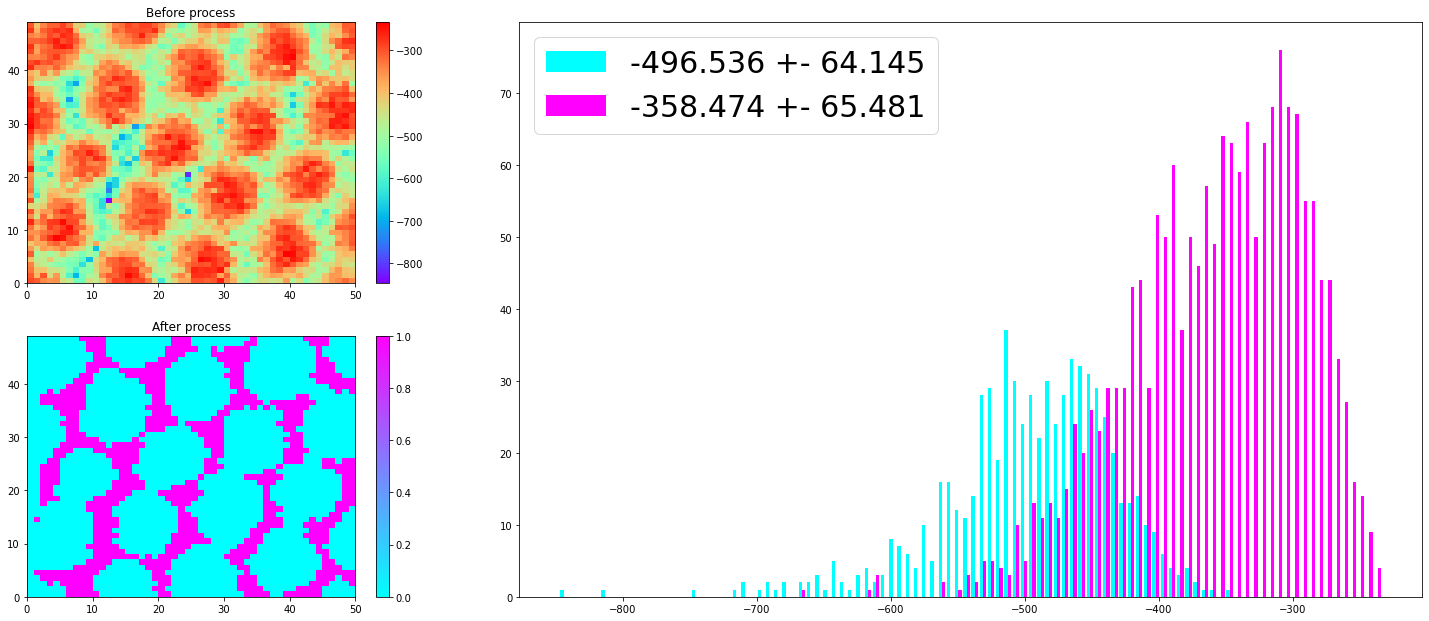

../data/221115_review/C_221015_480nm_positive/22o15009.abf_EMF_div-pqty=25.csv
../data/221115_review/C_221015_480nm_positive/22o15009.abf_current_div-pqty=25.csv
737


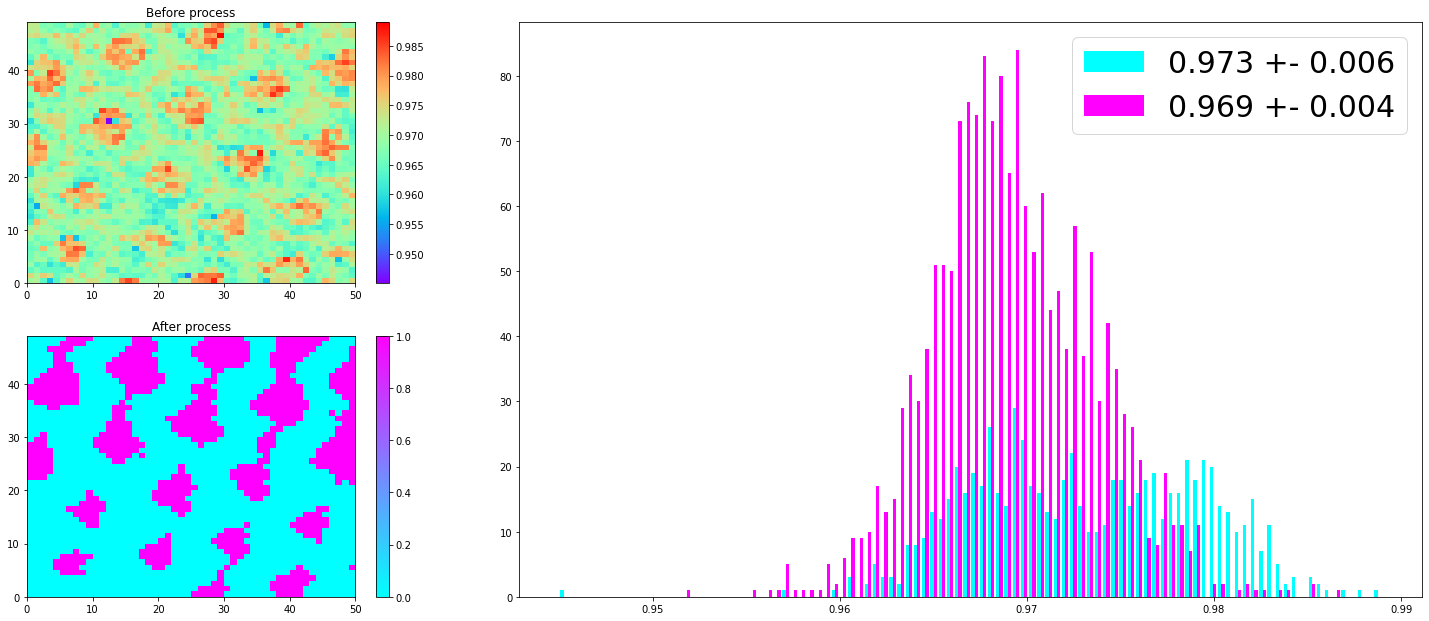

../data/221115_review/C_221015_480nm_positive/22o15009.abf_EMF_subs-pqty=25.csv
../data/221115_review/C_221015_480nm_positive/22o15009.abf_current_subs-pqty=25.csv
696


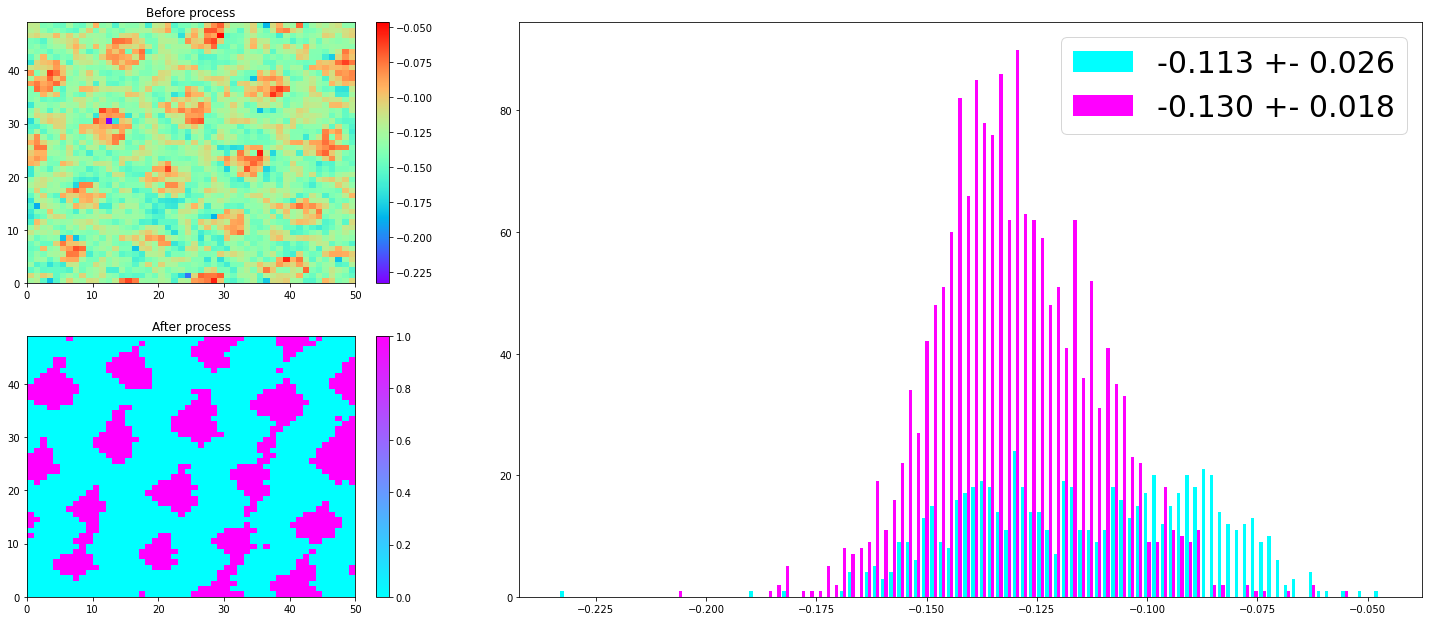

../data/221115_review/C_221015_480nm_positive/22o15009.abf_EMF_div-pqty=25.csv
737


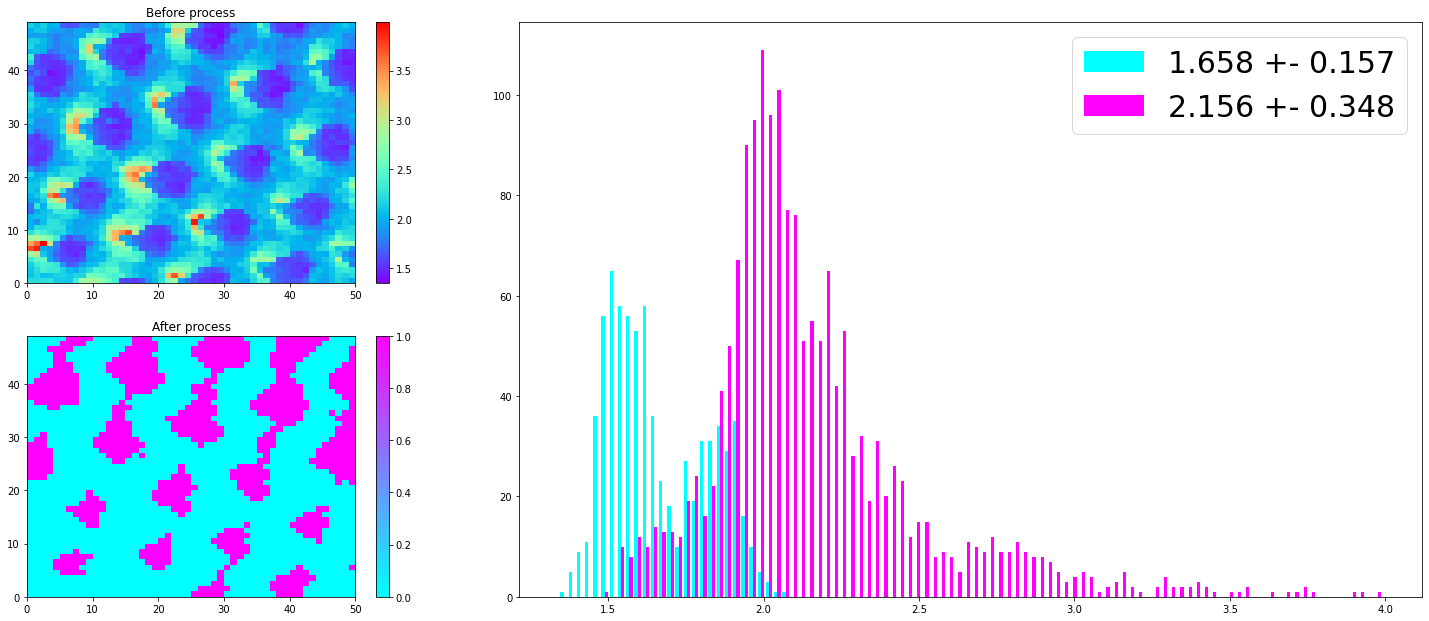

../data/221115_review/C_221015_480nm_positive/22o15009.abf_EMF_subs-pqty=25.csv
696


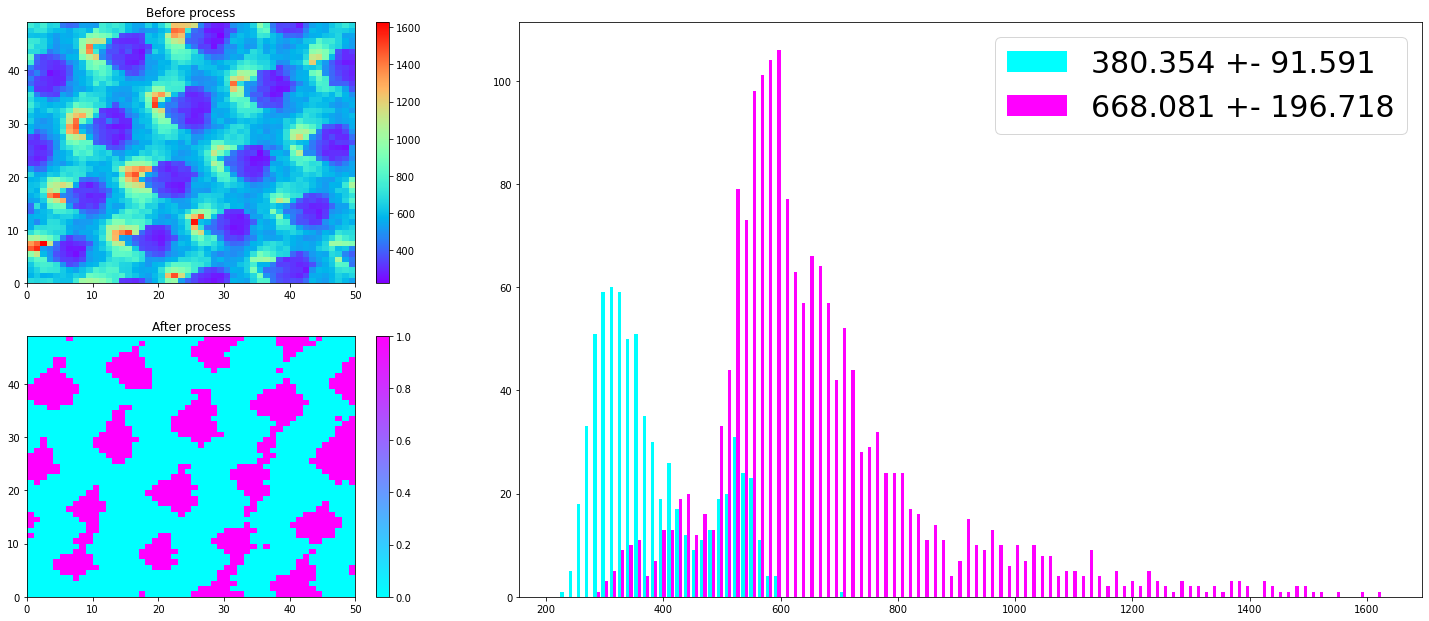

../data/221115_review/D_221011_750nm_negative/22o15013.abf_EMF_div-pqty=25.csv
../data/221115_review/D_221011_750nm_negative/22o15013.abf_current_div-pqty=25.csv
855


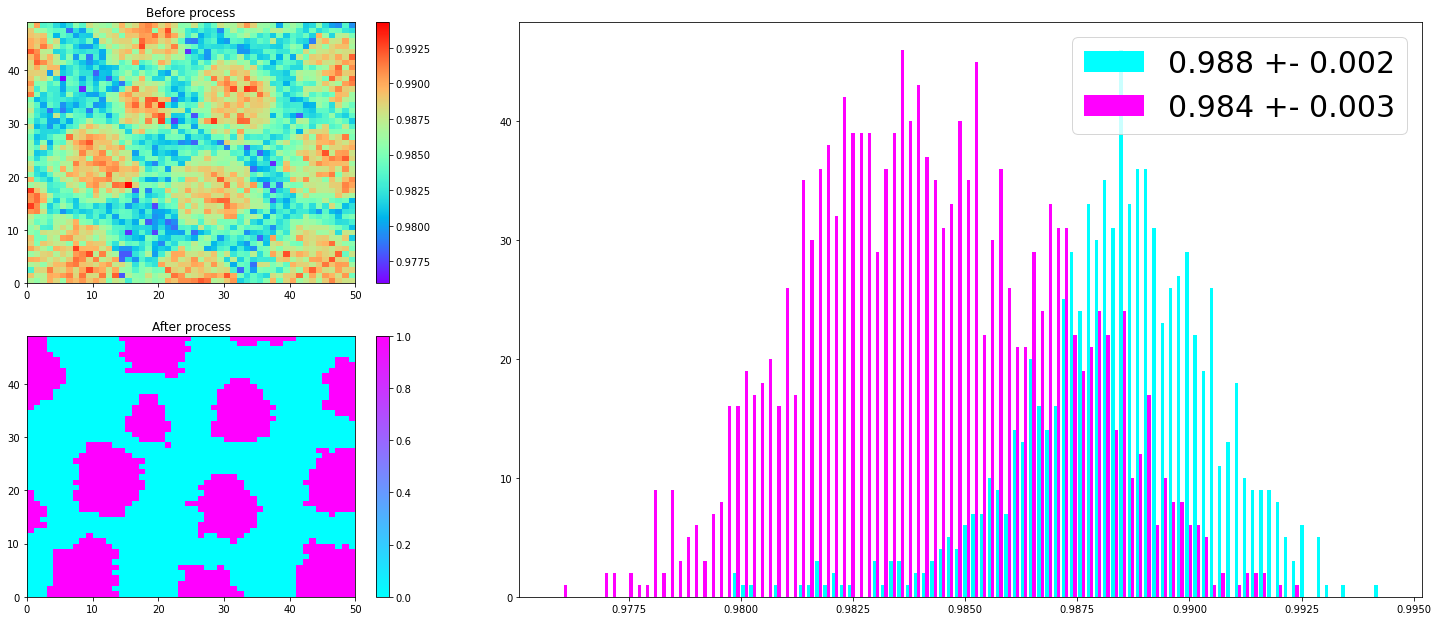

../data/221115_review/D_221011_750nm_negative/22o15013.abf_EMF_subs-pqty=25.csv
../data/221115_review/D_221011_750nm_negative/22o15013.abf_current_subs-pqty=25.csv
835


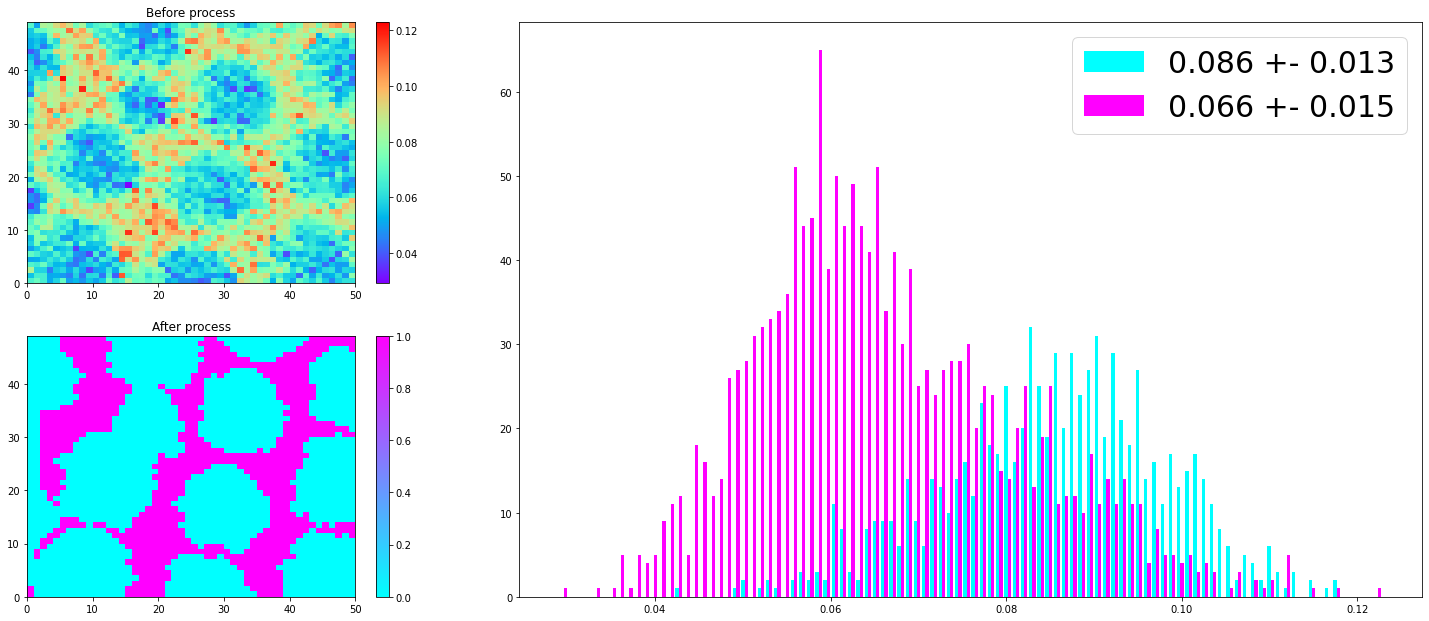

../data/221115_review/D_221011_750nm_negative/22o15013.abf_EMF_div-pqty=25.csv
855


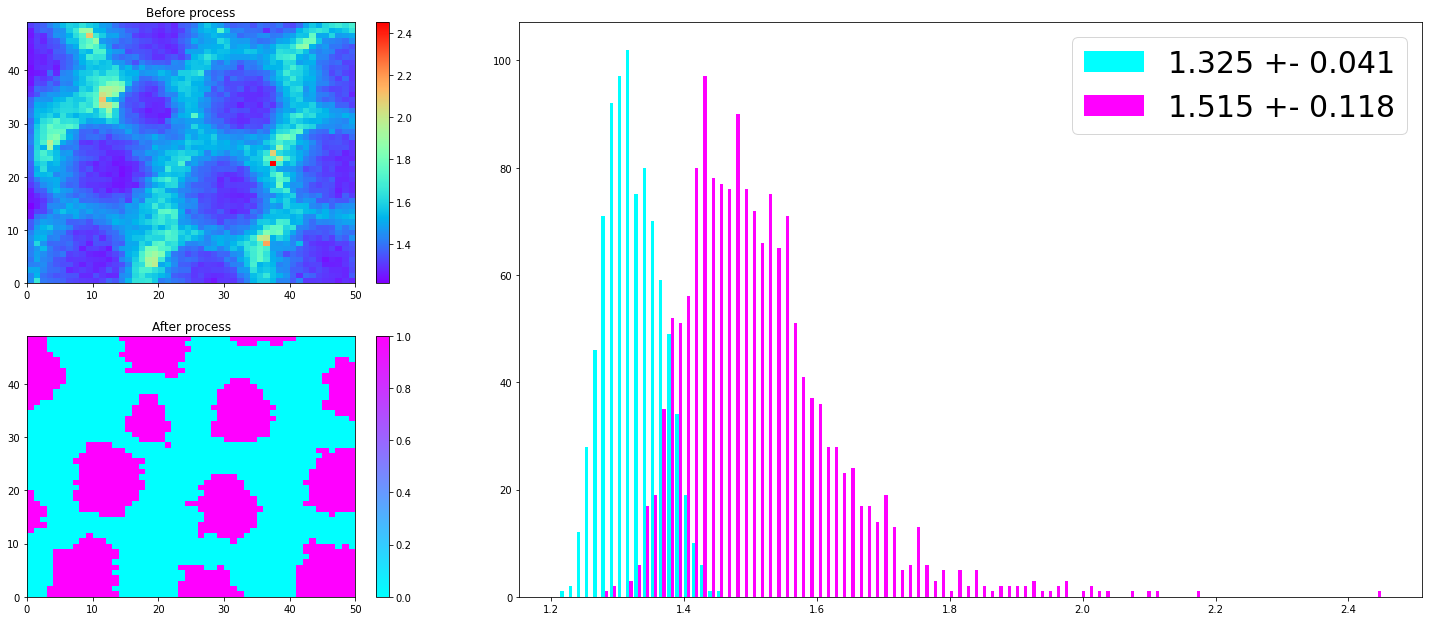

../data/221115_review/D_221011_750nm_negative/22o15013.abf_EMF_subs-pqty=25.csv
835


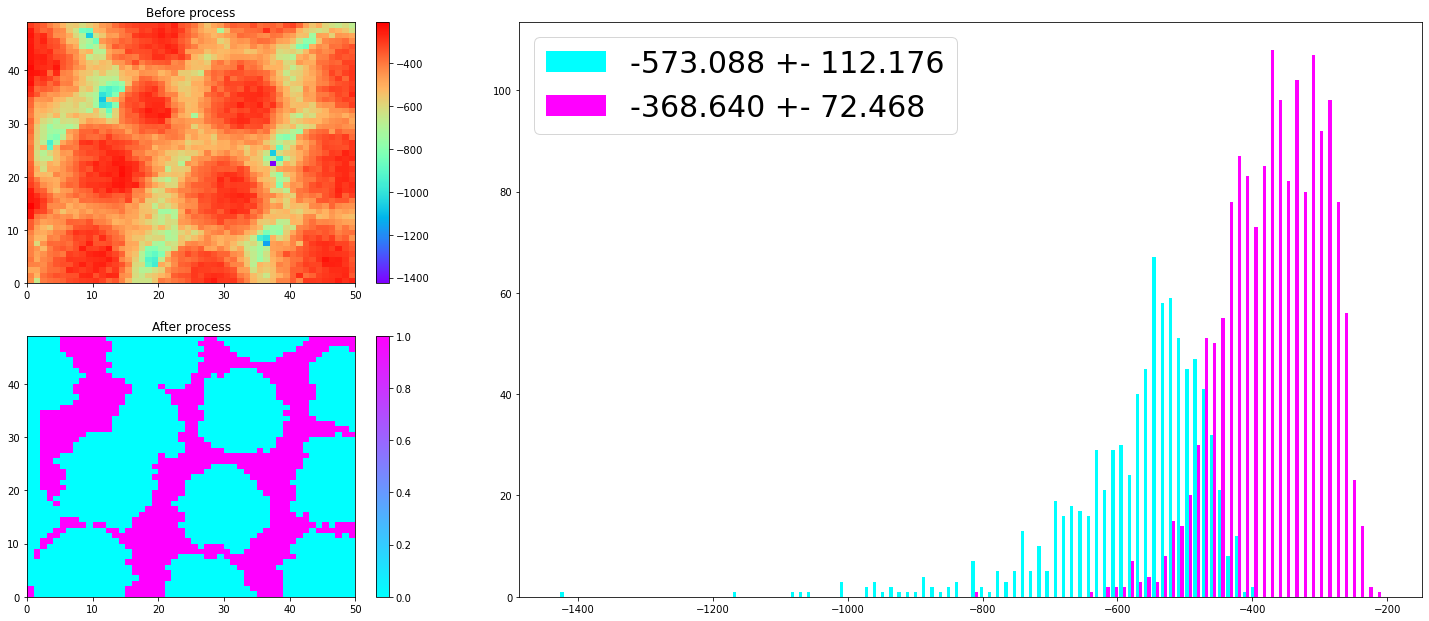

../data/221115_review/D_221011_750nm_postive/22o15012.abf_EMF_div-pqty=25.csv
../data/221115_review/D_221011_750nm_postive/22o15012.abf_current_div-pqty=25.csv
796


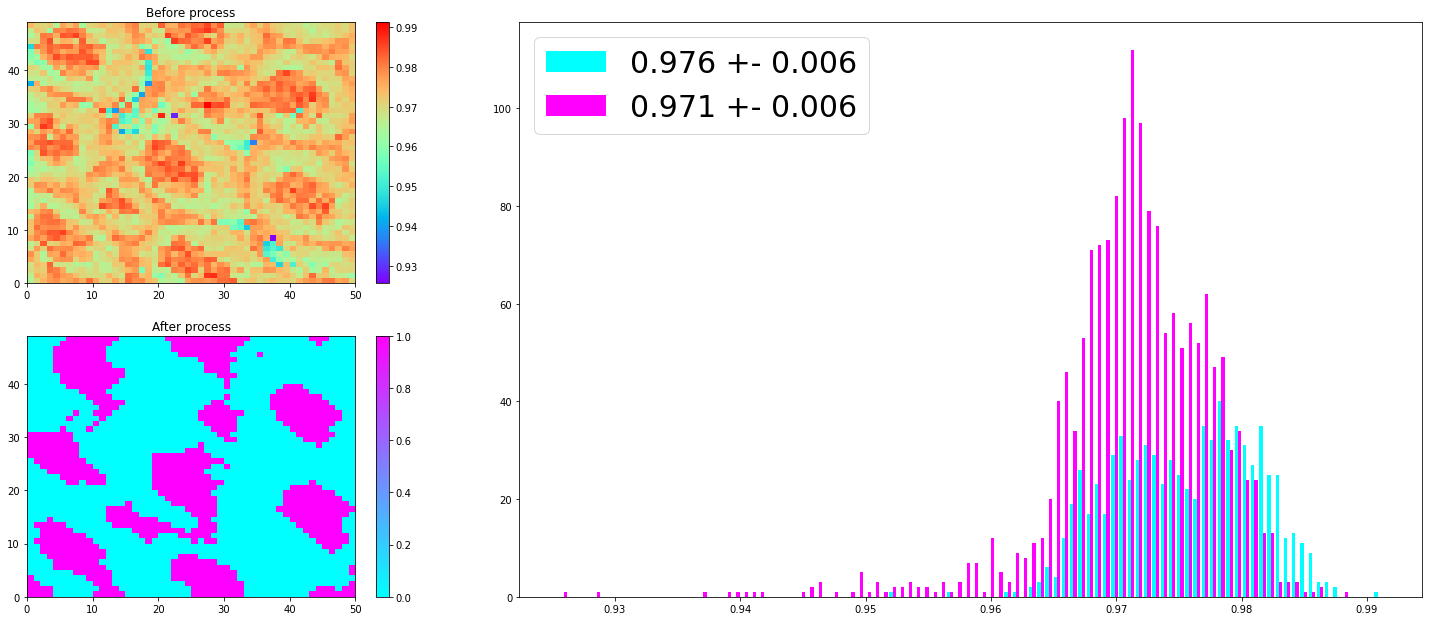

../data/221115_review/D_221011_750nm_postive/22o15012.abf_EMF_subs-pqty=25.csv
../data/221115_review/D_221011_750nm_postive/22o15012.abf_current_subs-pqty=25.csv
782


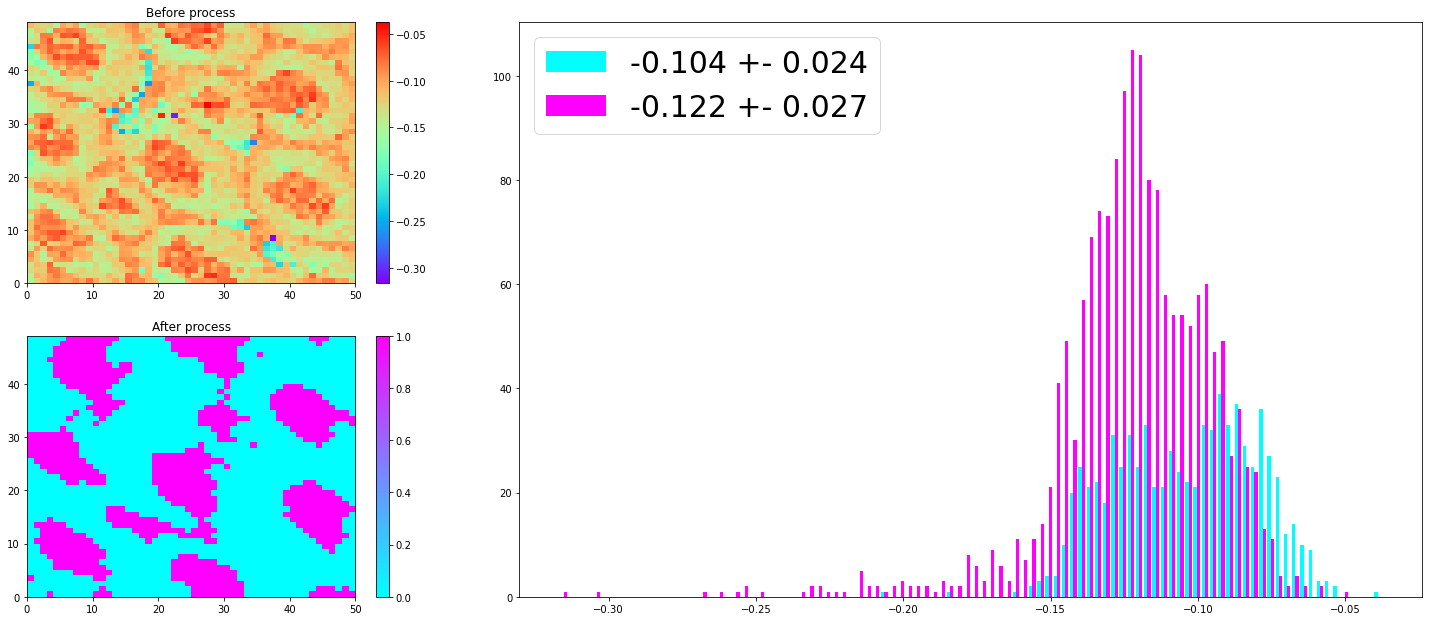

../data/221115_review/D_221011_750nm_postive/22o15012.abf_EMF_div-pqty=25.csv
796


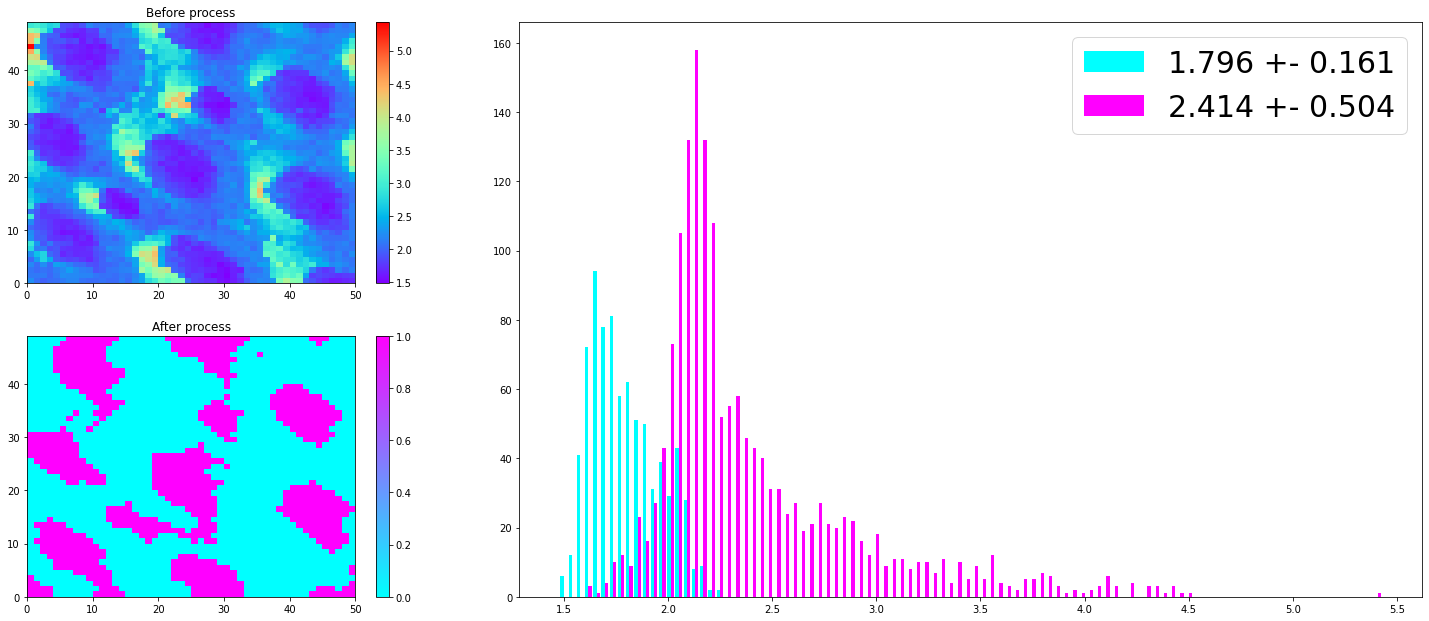

../data/221115_review/D_221011_750nm_postive/22o15012.abf_EMF_subs-pqty=25.csv
782


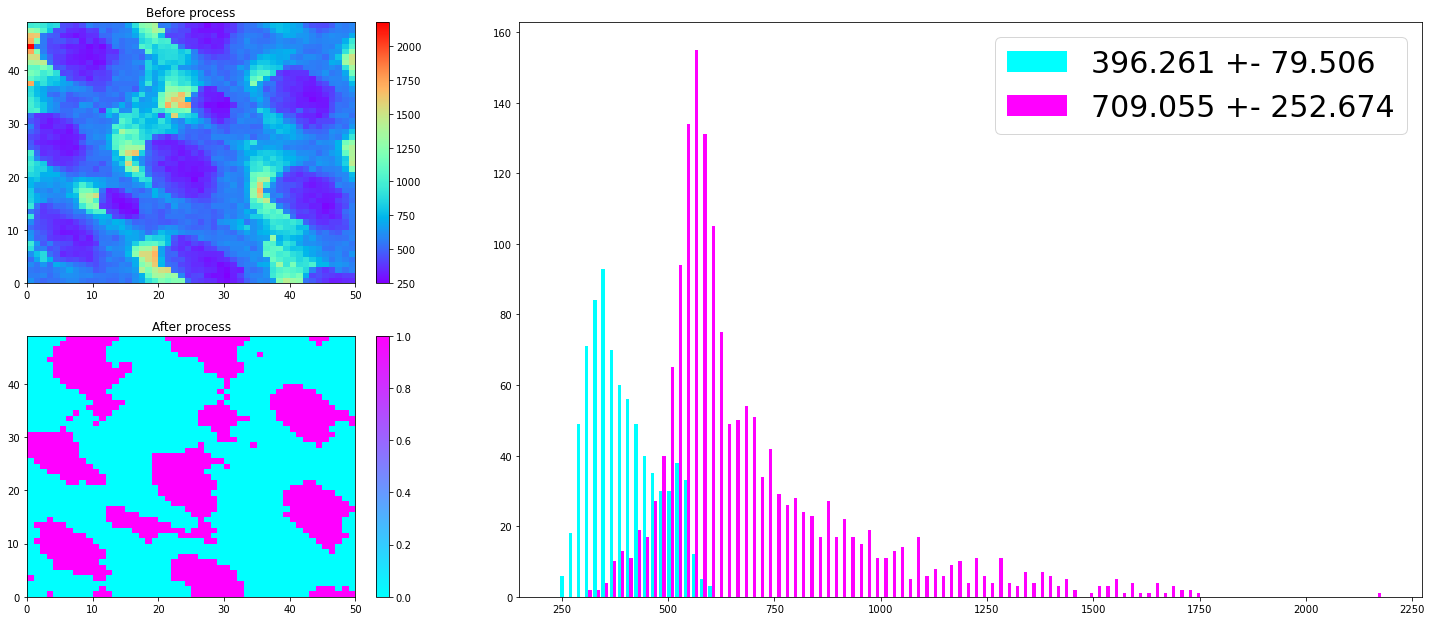

In [73]:
for f in files:
    if "EMF_" in f and ("div" in f or "subs" in f):
        dfs_emf(f)
    elif "current_" in f and ("div" in f or "subs" in f):
        dfs_cur(f)